# Segmentation comparsion - Otsu vs. Gradient matching
use global gradient match threshold 

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 1
%reload_ext autoreload

import sys, os, time

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
sys.path.append(os.path.join(os.environ['REPO_DIR'], 'cells'))
# sys.path.append(os.path.join(os.environ['REPO_DIR'], 'annotation'))
# sys.path.append(os.path.join(os.environ['REPO_DIR'], 'learning'))

import numpy as np
from skimage.measure import regionprops
from skimage.filters import threshold_otsu
from scipy.ndimage.morphology import distance_transform_edt
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from skimage.measure import regionprops, label, find_contours
from skimage.transform import resize
from skimage.color import rgb2hsv
from scipy import ndimage as ndi
import pandas
from scipy.signal import argrelmax
from scipy.stats import linregress
import scipy

from annotation_utilities import *
from registration_utilities import *
from learning_utilities import *
from data_manager import *



Setting environment for AWS compute node


/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
No vtk


In [2]:
# Function to find the threshold by gradient alignemnt

# def fun_threshold_gradAlig(image,scanrange=(160,240),step=5,o_size_gaussfilt=1,o_return_scores=False,show_score_plot=True,method='avg_dot_pdt'):
#     """
#         image: a grayscale image(0-255)
#         step: step for grayscale scan. can be integer number larger than 0
#         o_size_gaussfilt: size of the gaussian filter. 
#                           Not apply the gaussian filter to the image if equals 0
#         method: (1)tot_dot_pdt; (2)avg_cos
#         package needed: scipy.ndimage as ndi; numpy as np; matplotlib.pyplot as plt;  
        
#     """
#     if o_size_gaussfilt > 0:
#         tempImage = ndi.filters.gaussian_filter(image, o_size_gaussfilt)
#     else:
#         tempImage = image
#     gradX, gradY = np.gradient(tempImage)
#     image_size = image.size
#     temp_TH_aggrement = {}
    
#     for tempTH in np.arange(scanrange[0],scanrange[1],step):
#         tempGx, tempGy = np.gradient((tempImage < tempTH).astype(float))
#         nz = np.logical_and(np.logical_or(tempGx != 0, tempGy != 0),np.logical_or(gradX != 0, gradY != 0))
#         if np.count_nonzero(nz) == 0:
#             temp_TH_aggrement[tempTH] = 0
#         else:
#             if method == 'tot_dot_pdt':
#                 temp_TH_aggrement[tempTH] = np.sum(tempGx[nz]*gradX[nz] + tempGy[nz]*gradY[nz])

#             if method == 'avg_dot_pdt':
#                 temp_TH_aggrement[tempTH] = (tempGx[nz]*gradX[nz] + tempGy[nz]*gradY[nz]).mean()

#             if method == 'avg_cos':
#                 grad_norm = np.sqrt( gradX[nz] ** 2 + gradY[nz] ** 2 )
#                 tempG_norm = np.sqrt( tempGx[nz] ** 2 + tempGy[nz] ** 2 )
#                 temp_TH_aggrement[tempTH] = ((tempGx[nz]*gradX[nz] + tempGy[nz]*gradY[nz])/(tempG_norm * grad_norm)).mean()
    
#     tempKeys, tempValues = zip(*sorted(temp_TH_aggrement.items()))
#     grad_threshold = tempKeys[np.argmax(tempValues)]
    
#     if show_score_plot==True:
#         fig_grad_THscan_score = plt.figure()
#         fig_grad_THscan_score = plt.plot(tempKeys, tempValues)
#         fig_grad_THscan_score = plt.xlabel('Grayscale threshold')
#         fig_grad_THscan_score = plt.ylabel('Score')
#         fig_grad_THscan_score = plt.title('Score method used: '+method+'\nBest threshold = %s' % grad_threshold)
#         fig_grad_THscan_score = plt.grid(True)
#     if o_return_scores==True:
#         return grad_threshold,[tempKeys,tempValues]
#     else:
#         return grad_threshold    

In [3]:
import skimage

%autoreload 1
save_folder_path = '/shared/MouseBrainAtlasXiang/XJ/Output/Seg_method_comparison_whole_image/'
from xj_utilities import *
fun_create_folder(save_folder_path=save_folder_path)

Folder already exists: /shared/MouseBrainAtlasXiang/XJ/Output/Seg_method_comparison_whole_image/

In [4]:
stack = 'MD589'
metadata_cache['section_limits'][stack]
patch_size = 448
patch_half_size = patch_size / 2
stride = 112
# Crop images
# 
crop_x_min = 9000
crop_x_max = 10500
crop_y_min = 3000
crop_y_max = 4500

# Inside
# crop_x_min = 4000
# crop_x_max = 6000
# crop_y_min = 2400
# crop_y_max = 4400

# Whole
# crop_x_min = 0
# crop_y_min = 0
# _, _, crop_y_max, crop_x_max = get_default_gridspec(stack=stack, patch_size=patch_size, stride=stride)

crop_image_width = crop_y_max - crop_y_min
crop_image_height = crop_x_max - crop_x_min

patch_center_pixel_location = grid_parameters_to_sample_locations((patch_size, stride, crop_image_width, crop_image_height ))
patch_ul = patch_center_pixel_location + ( - patch_half_size, - patch_half_size )
patch_ur = patch_center_pixel_location + ( - patch_half_size,   patch_half_size )
patch_dl = patch_center_pixel_location + (   patch_half_size, - patch_half_size )
patch_dr = patch_center_pixel_location + (   patch_half_size,   patch_half_size )
patch_contour = np.array(zip(patch_ul, patch_ur, patch_dr, patch_dl))

# Options
option_rescale_grayscale = True
option_THimage_save = True;
option_save_image_extension = '.png'

# Process images
option_label_connectivity = 4;

In [5]:
# Set examine section number range and download from S3 if not available
img_filename = []
secIndexList = range(200, 210)
n_images=0
for tempIndex1 in range(len(secIndexList)):
    if is_invalid(stack=stack, sec=secIndexList[tempIndex1]):
        secIndexList[tempIndex1]=-1
        sys.stderr.write('Invalid section sec = %s \n'%tempIndex1)

    else:
        img_filename.append(DataManager.get_image_filepath(stack=stack, section=secIndexList[tempIndex1], resol='lossless', version='cropped'))
        if os.path.isfile(img_filename[n_images]):
            sys.stderr.write('Image files are already available. \n')
            
        else:
            try:
                download_from_s3(img_filename[n_images])
            except:
                sys.stderr.write('Download fail. Skip this file...\n')
                          
        n_images = n_images + 1
while secIndexList.count(-1)>0:
    secIndexList.remove(-1)
n_images = len(img_filename)

Image files are already available. 
Image files are already available. 
Image files are already available. 
Image files are already available. 
Image files are already available. 
Image files are already available. 
Image files are already available. 
Image files are already available. 
Image files are already available. 
Image files are already available. 


In [6]:
# Read images
option_rescale_grayscale = True
option_inverse_color = False

im_cropped = []
for imIndex in img_filename:
# for imIndex in [img_filename[0]]:
    if option_rescale_grayscale == False:
        im_cropped.append(img_as_ubyte(rgb2gray(imread(imIndex)[crop_x_min:crop_x_max, crop_y_min:crop_y_max])))
    else:
        im_cropped.append(fun_rescale_grayscale_image(img_as_ubyte(rgb2gray(imread(imIndex)[crop_x_min:crop_x_max, crop_y_min:crop_y_max])),invcol=option_inverse_color))

/usr/local/lib/python2.7/dist-packages/skimage/external/tifffile/tifffile.py:2611: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)
/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


0
1
2
3
4
5
6


/usr/local/lib/python2.7/dist-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


7
8
9


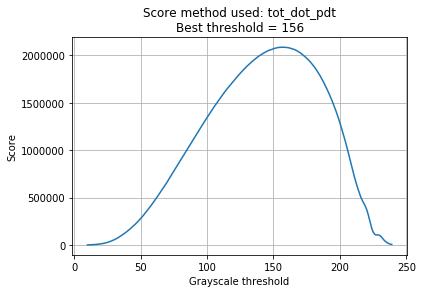

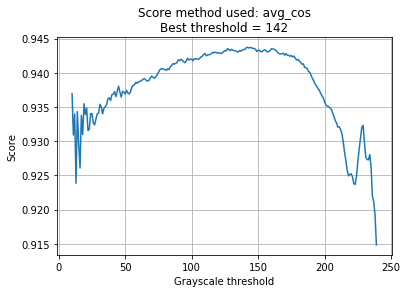

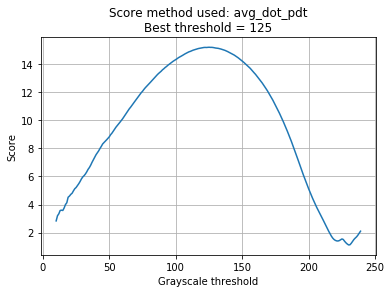

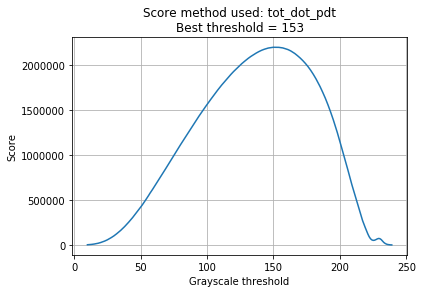

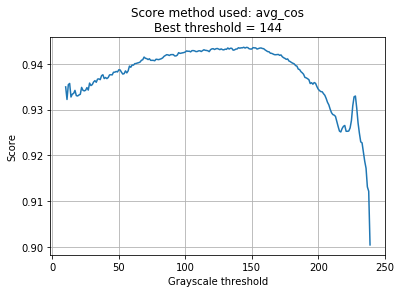

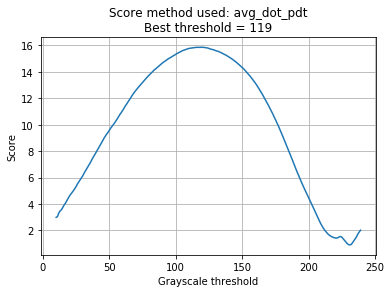

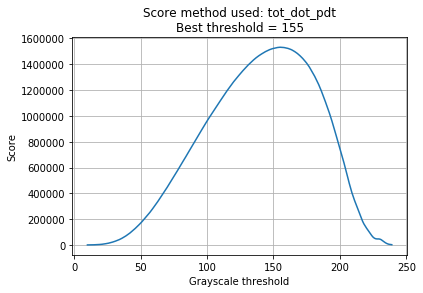

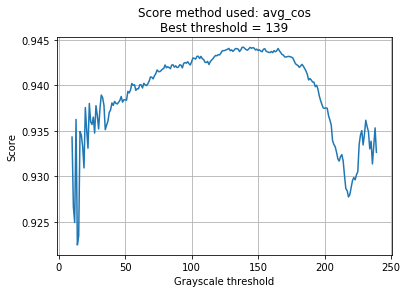

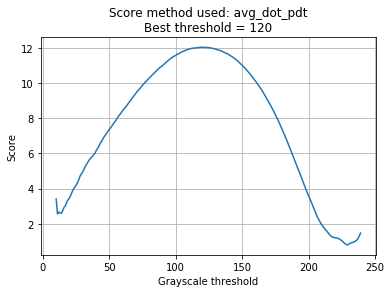

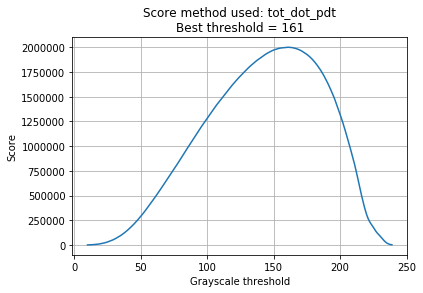

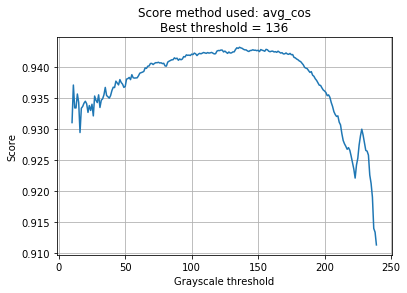

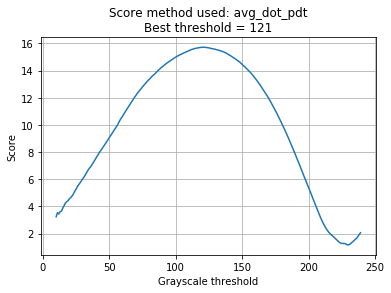

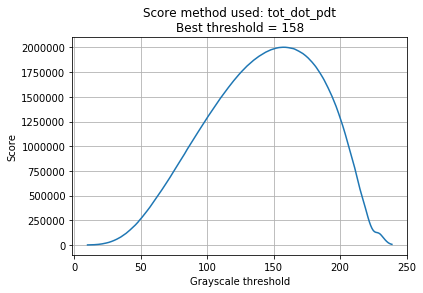

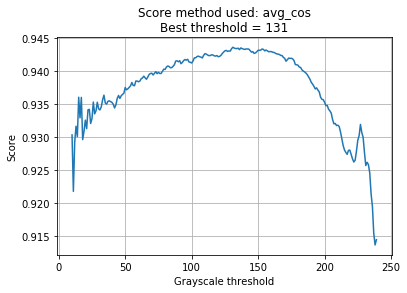

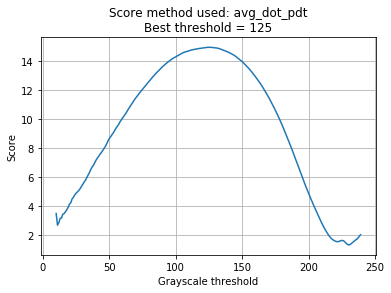

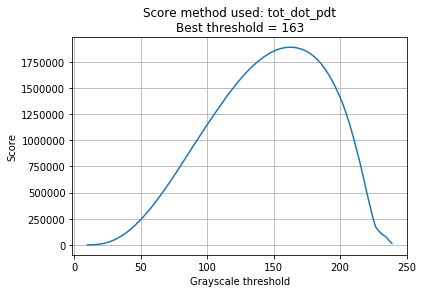

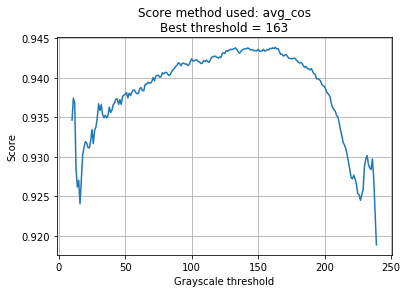

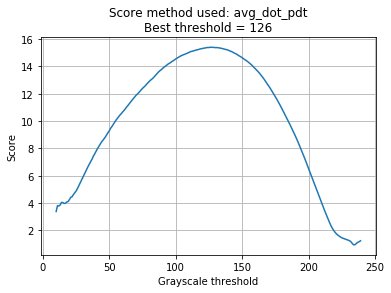

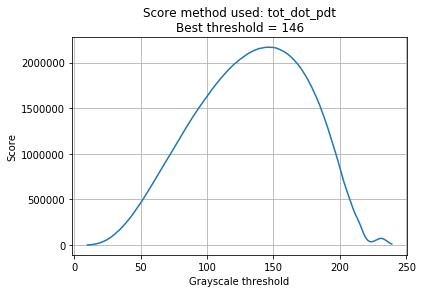

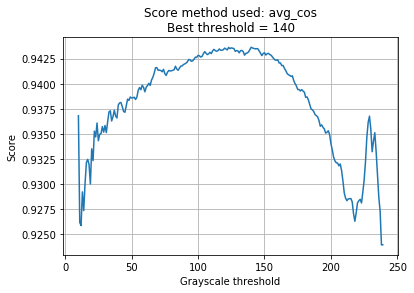

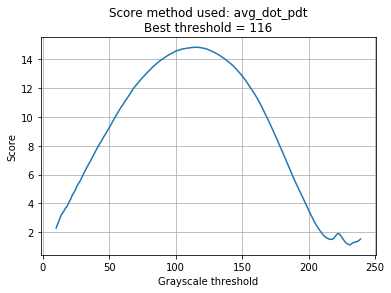

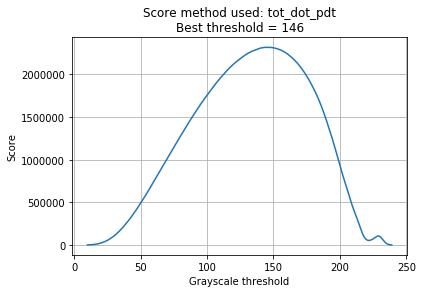

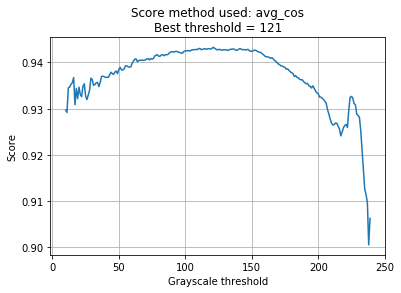

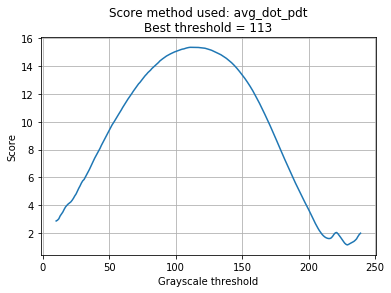

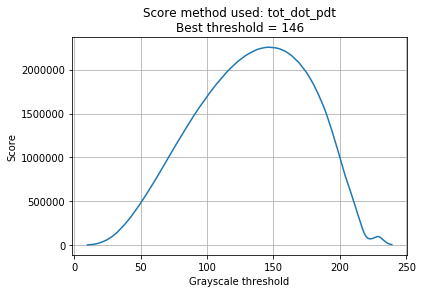

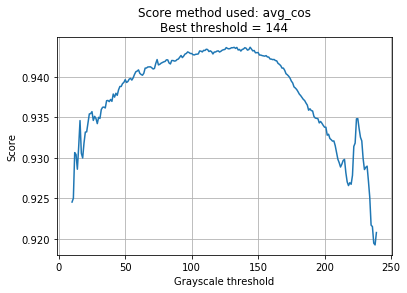

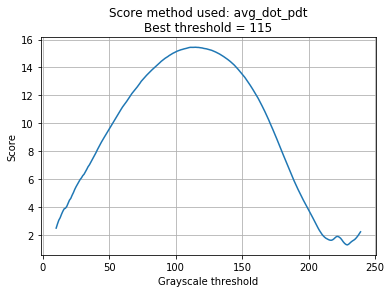

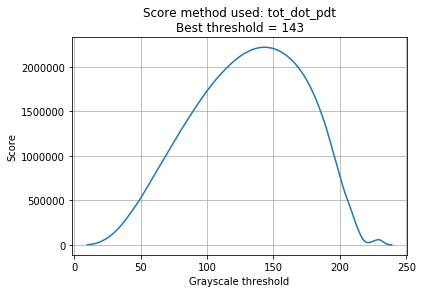

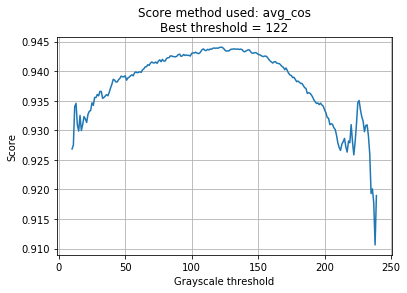

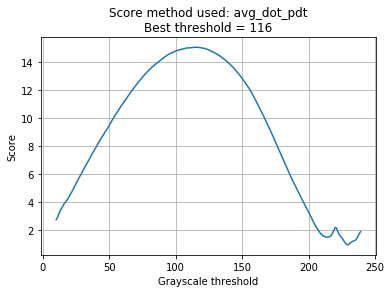

In [7]:
# Processes images
otsu_th = []
grad_align_th_dps = []
grad_align_th_cos = []
grad_align_th_dpa = []
im_BW_otsu = []
im_BW_GA = []
option_get_otsu = True
option_get_grad_align = True
option_get_grad_align_cos = True
option_get_grad_align_dpa = True
option_get_grad_align_dps = True
secIndex = 0
for imIndex in range(n_images):
    tempImage = im_cropped[imIndex]
    if option_get_otsu:
        otsu_th.append(skimage.filters.threshold_otsu(tempImage))
#         im_BW_otsu.append(tempImage < otsu_th[imIndex])
    if option_get_grad_align:
        print(imIndex)
        if option_get_grad_align_dps:
            grad_align_th_dps.append(fun_threshold_gradAlig(tempImage,scanrange=(10,240),step=1,show_score_plot=True,method='tot_dot_pdt'))
        if option_get_grad_align_cos:
            grad_align_th_cos.append(fun_threshold_gradAlig(tempImage,scanrange=(10,240),step=1,show_score_plot=True,method='avg_cos'))
        if option_get_grad_align_dpa:
            grad_align_th_dpa.append(fun_threshold_gradAlig(tempImage,scanrange=(10,240),step=1,show_score_plot=True,method='avg_dot_pdt'))
#         im_BW_GA.append(tempImage < grad_align_th[imIndex])

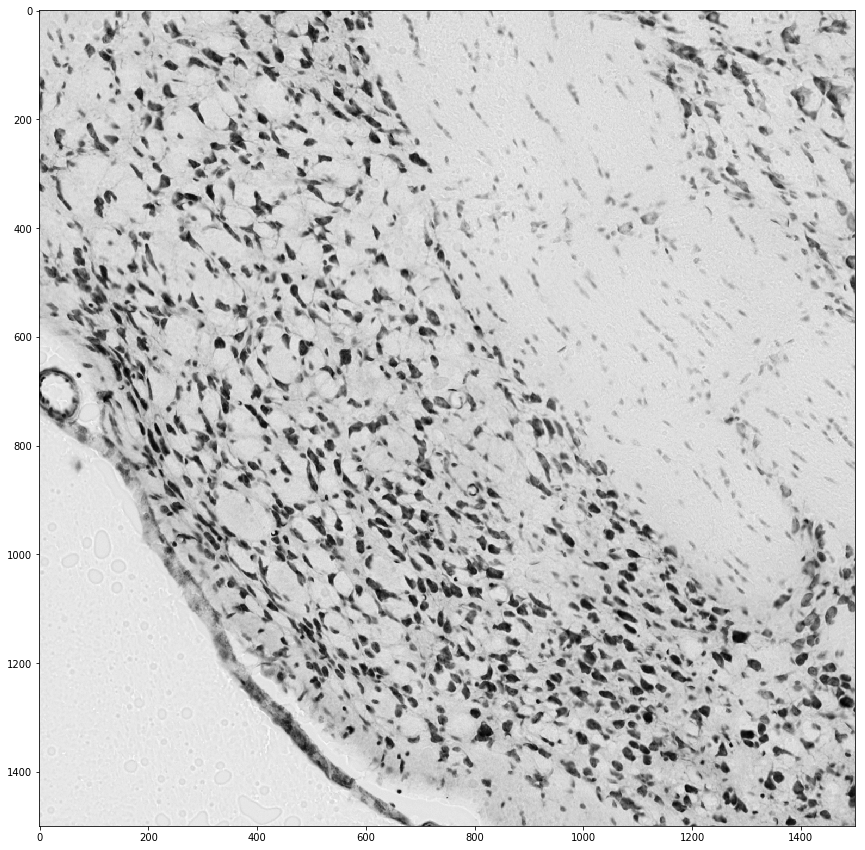

In [8]:
plt.figure(figsize=(15,15))
plt.imshow(im_cropped[0],cmap=plt.cm.gray)

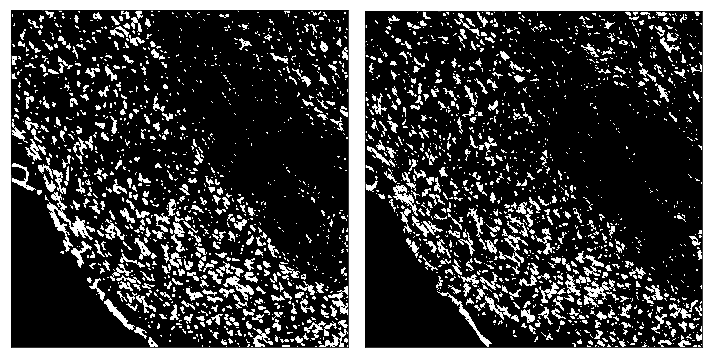

In [9]:
# plt.figure(figsize=(15,15))
display_images_in_grids([im_cropped[2]<grad_align_th_dps[2],im_cropped[3]<grad_align_th_dps[3]],nc=2,cmap=plt.cm.gray)

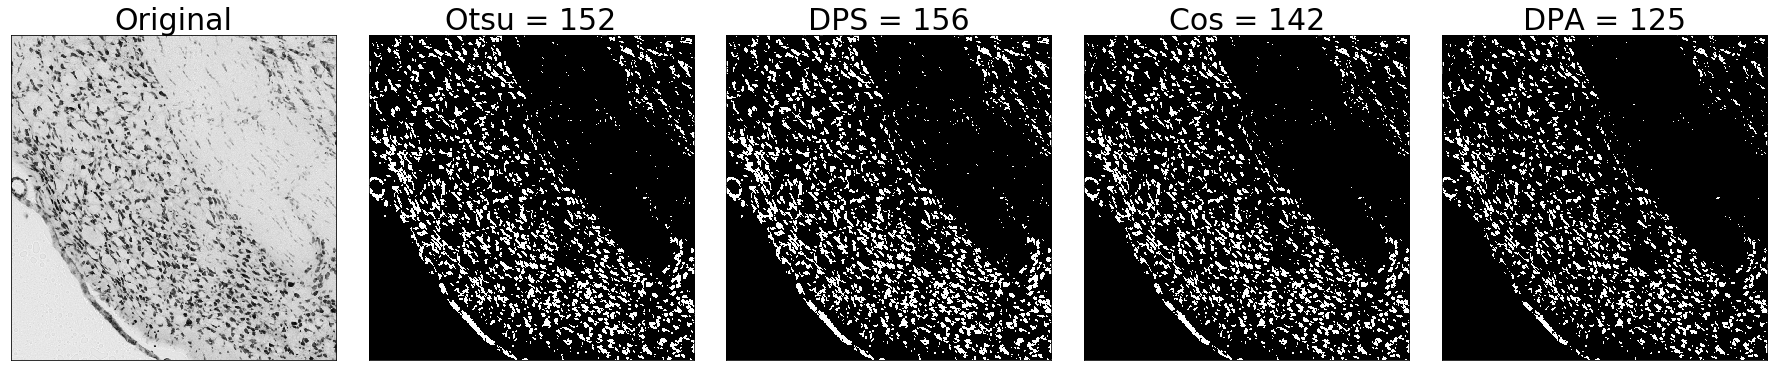

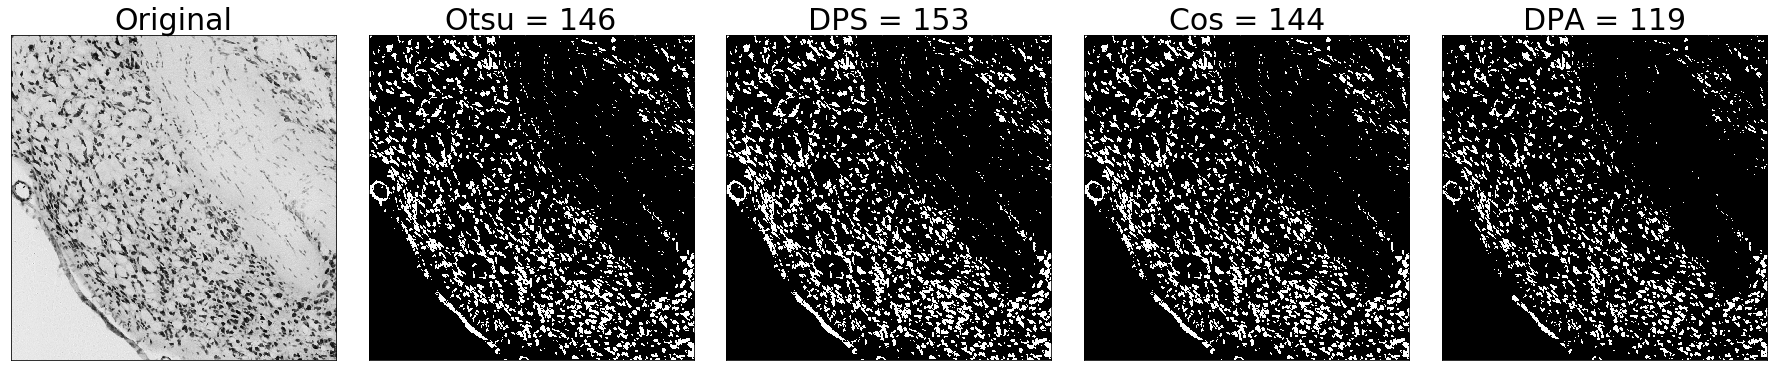

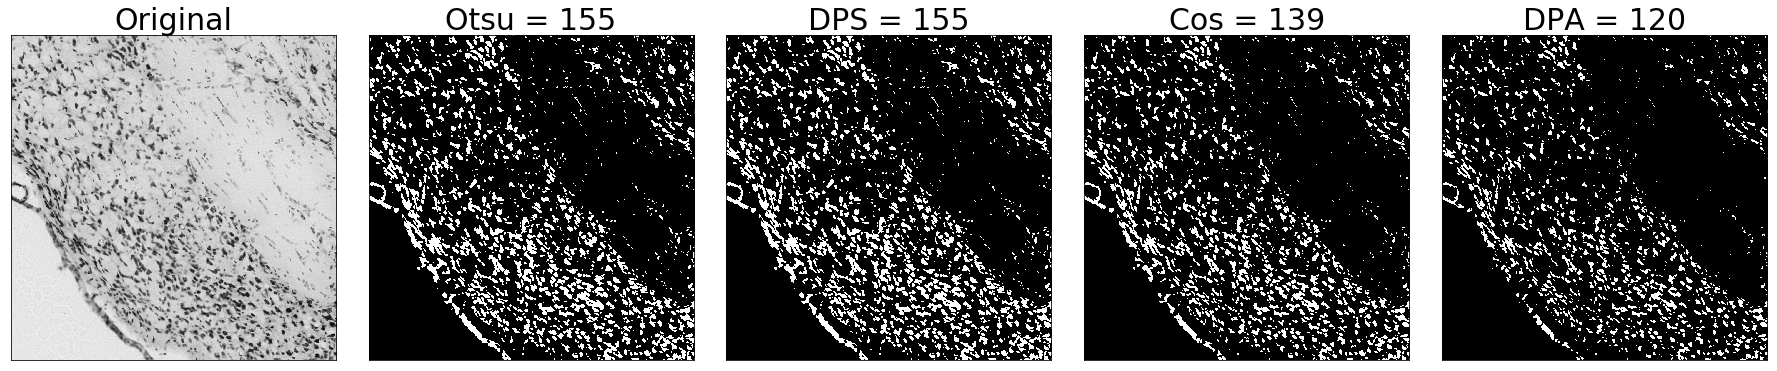

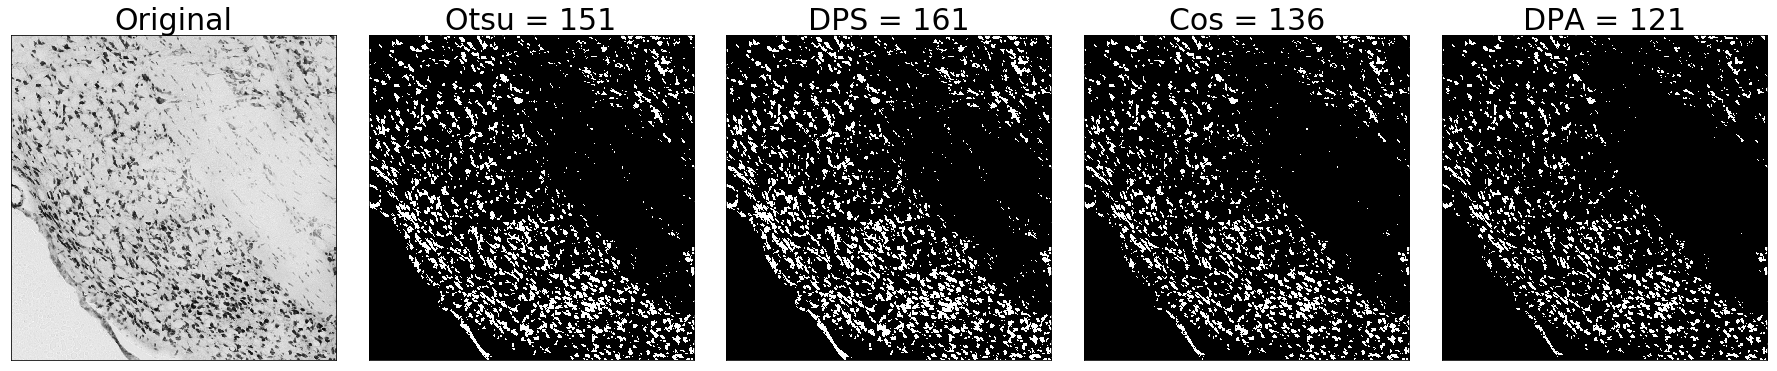

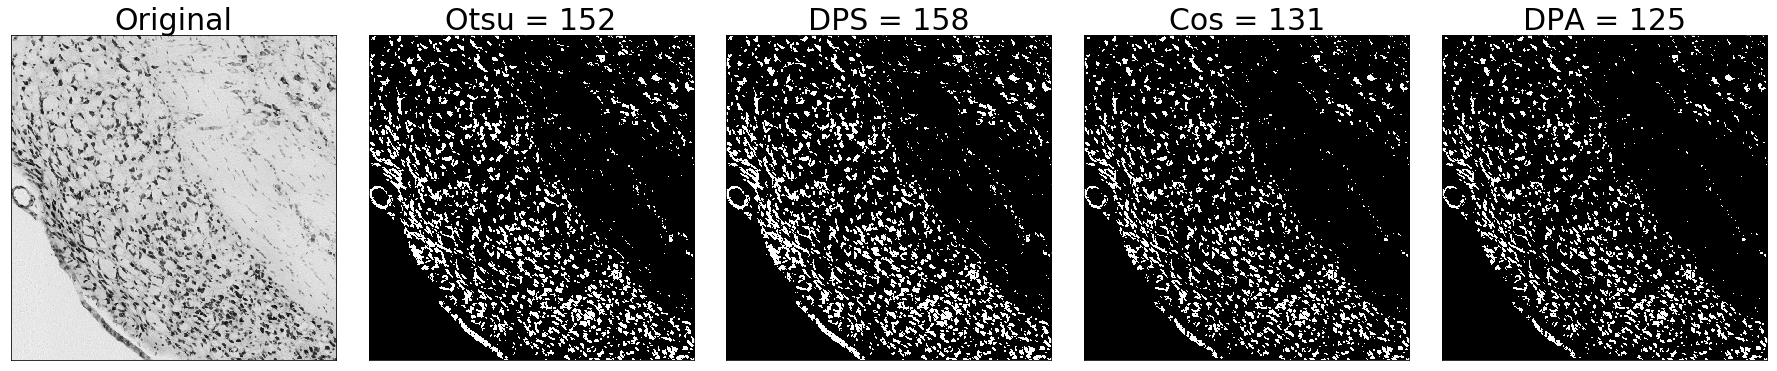

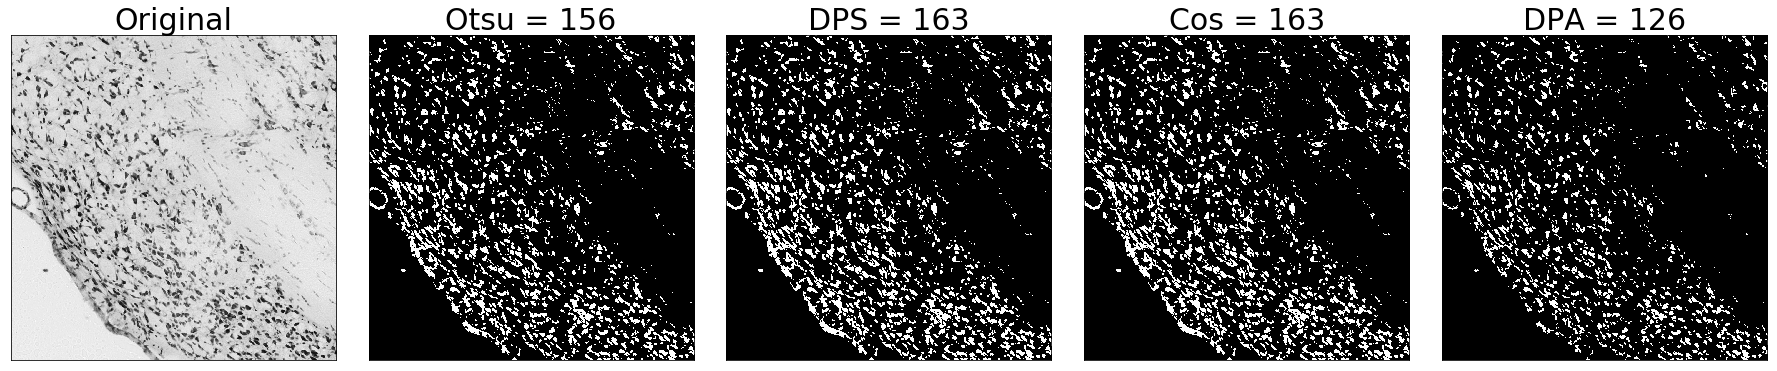

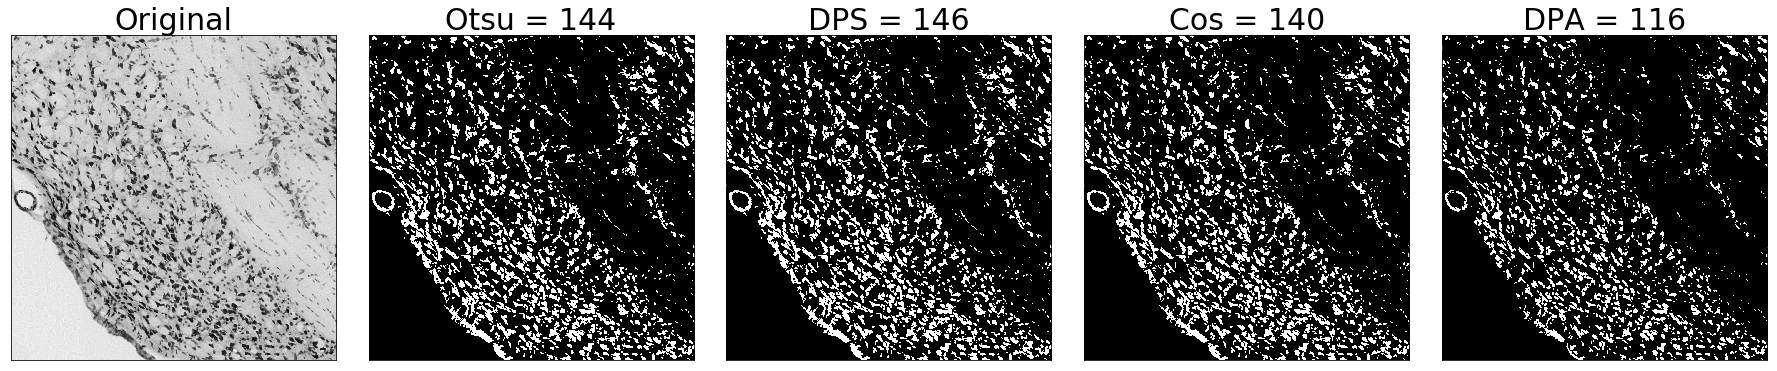

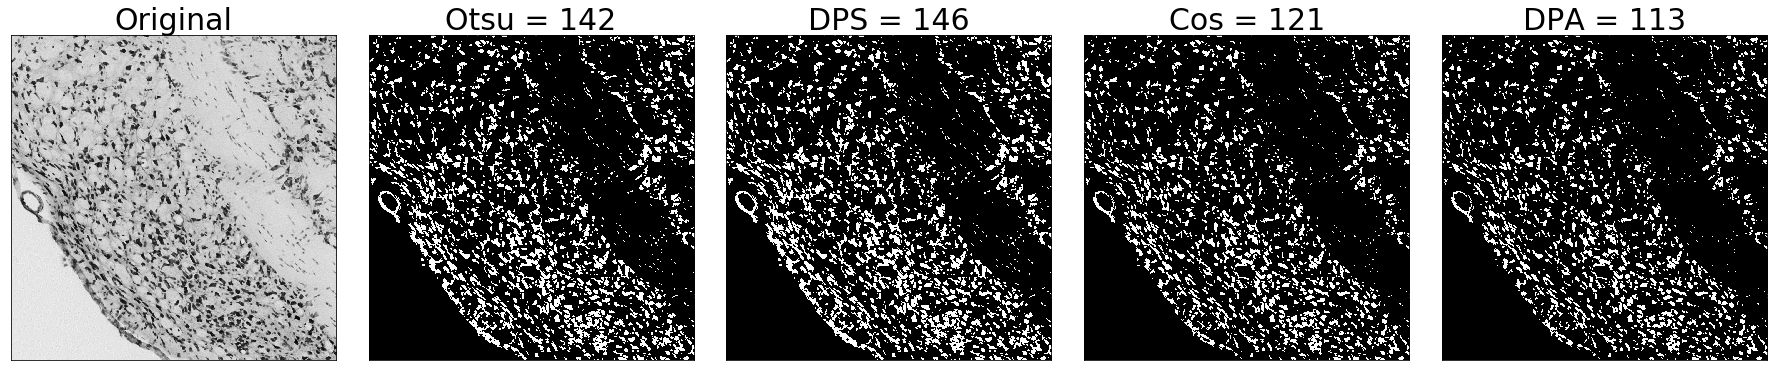

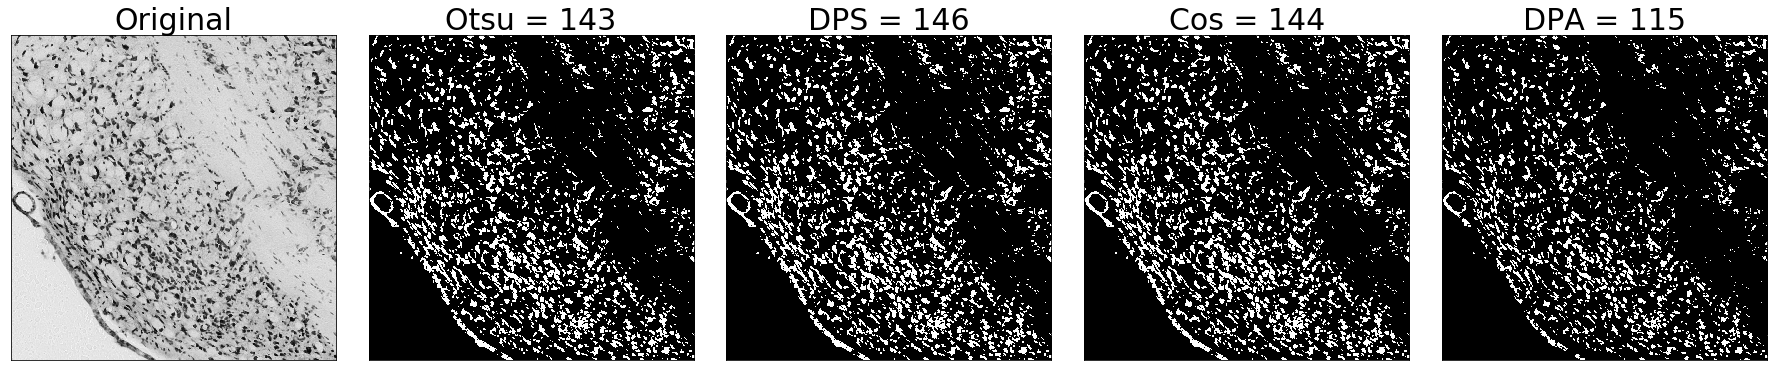

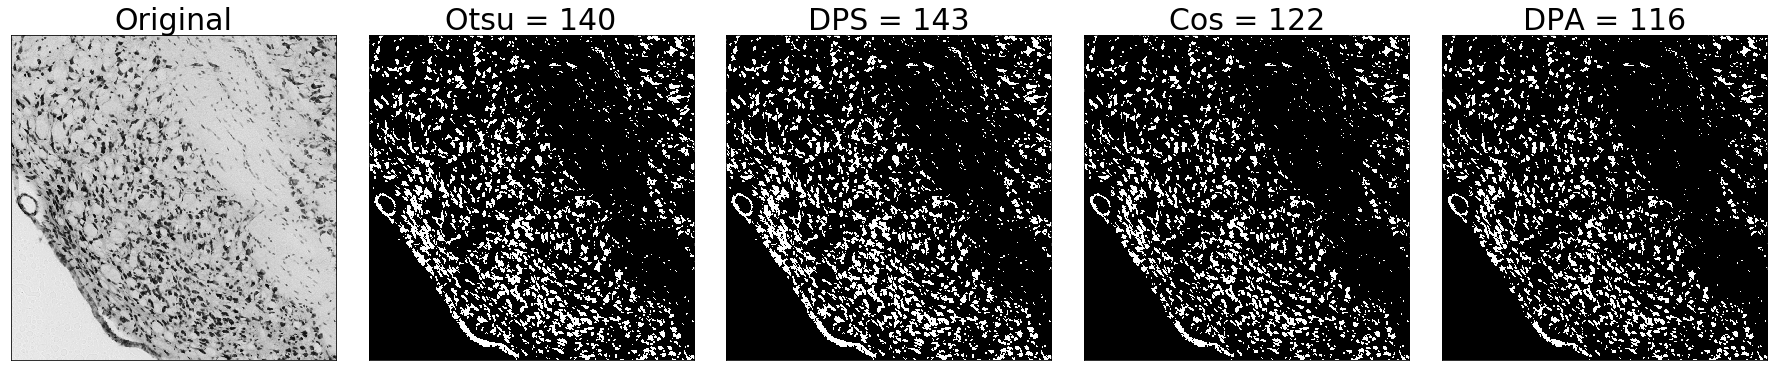

In [10]:
# Method comparison: visualize the BW images
for imIndex in range(len(otsu_th)):
    display_images_in_grids([im_cropped[imIndex],
                             im_cropped[imIndex]<otsu_th[imIndex],
                             im_cropped[imIndex]<grad_align_th_dps[imIndex],
                            im_cropped[imIndex]<grad_align_th_cos[imIndex],
                            im_cropped[imIndex]<grad_align_th_dpa[imIndex]],titles=['Original','Otsu = %d' %otsu_th[imIndex],'DPS = %d' %grad_align_th_dps[imIndex],
                                                                                   'Cos = %d' %grad_align_th_cos[imIndex],'DPA = %d' %grad_align_th_dpa[imIndex]],nc=5,cmap=plt.cm.gray)

/usr/local/lib/python2.7/dist-packages/matplotlib/pyplot.py:3429: MatplotlibDeprecationWarning: The 'hold' keyword argument is deprecated since 2.0.
  mplDeprecation)
/usr/local/lib/python2.7/dist-packages/matplotlib/pyplot.py:3315: MatplotlibDeprecationWarning: The 'hold' keyword argument is deprecated since 2.0.
  mplDeprecation)


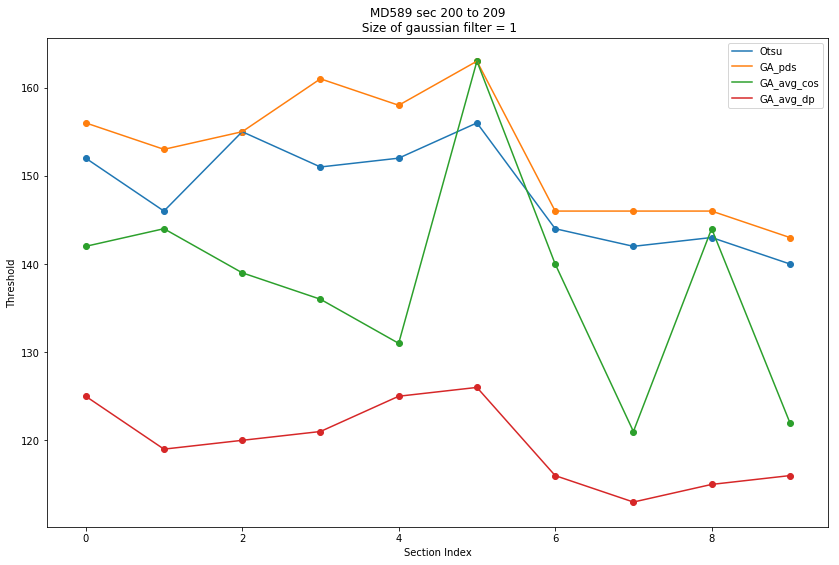

In [11]:
# Method comparison: threshold cross section:
fig_threshold_compare_xRange = np.arange(0,n_images,1,dtype=int)
fig_threshold_compare = plt.figure(figsize=(14,9))
fig_threshold_compare = plt.scatter(fig_threshold_compare_xRange,otsu_th,hold=True)
fig_threshold_compare = plt.scatter(fig_threshold_compare_xRange,grad_align_th_dps,hold=True)
fig_threshold_compare = plt.scatter(fig_threshold_compare_xRange,grad_align_th_cos,hold=True)
fig_threshold_compare = plt.scatter(fig_threshold_compare_xRange,grad_align_th_dpa,hold=True)
fig_threshold_compare = plt.plot(fig_threshold_compare_xRange,otsu_th,hold=True)
fig_threshold_compare = plt.plot(fig_threshold_compare_xRange,grad_align_th_dps,hold=True)
fig_threshold_compare = plt.plot(fig_threshold_compare_xRange,grad_align_th_cos,hold=True)
fig_threshold_compare = plt.plot(fig_threshold_compare_xRange,grad_align_th_dpa,hold=True)
fig_threshold_compare = plt.legend(['Otsu','GA_pds','GA_avg_cos','GA_avg_dp'])
fig_threshold_compare = plt.xlabel('Section Index')
fig_threshold_compare = plt.ylabel('Threshold')
fig_threshold_compare = plt.title(stack+' sec '+str(secIndexList[0])+' to '+str(secIndexList[-1])+'\n Size of gaussian filter = 1')

fig_threshold_compare_name = fun_construct_filename([stack,secIndexList[0],secIndexList[-1],crop_x_min,crop_x_max,crop_y_min,crop_y_max,'GFsize',1])
fig_threshold_compare.figure.savefig(save_folder_path+fig_threshold_compare_name+option_save_image_extension)


### Conclusion:
1. Otsu is good. 
2. Average cos and dot product is unstable. At lease, there are more than one peak on the score for grayscale from 0 to 255. Determine the range for calculating the score and getting the peak requires two more free parameters. 
3. Right now, the gradient matching algorithms is very very slow when applied to the whole image. Cannot finish in 35 minutes. 

# Global Threshold

In [12]:
# Otsu threashold
otsu_thresh = threshold_otsu(tempImage)
tempImage_BW = tempImage <= otsu_thresh

## Gradient Match - After global gaussian filter

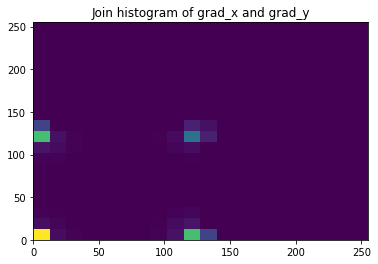

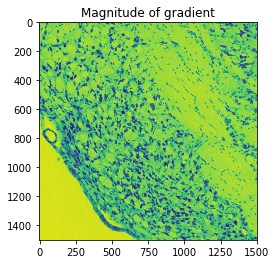

In [14]:
o_gass_filt_sigma = 1
tempImage_gf = ndi.filters.gaussian_filter(tempImage, o_gass_filt_sigma)

gradX_gf, gradY_gf = np.gradient(tempImage_gf)
grad_list_gf = np.transpose(np.stack([gradX_gf.flatten(),gradY_gf.flatten()]))
fig_hist_gxgy_gf = plt.figure()
fig_hist_gxgy_gf = plt.hist2d(gradX_gf.flatten(),gradY_gf.flatten(),20);
fig_hist_gxgy_gf = plt.title('Join histogram of grad_x and grad_y')

temp_grad_gray_gf = np.sqrt(gradX_gf ** 2 + gradY_gf **2)
fig_viz_grad_gray_gf = plt.figure()
fig_viz_grad_gray_gf = plt.imshow(tempImage_gf)
fig_viz_grad_gray_gf = plt.title('Magnitude of gradient')

In [16]:
# score = sum[cos<v1_i,v2_i>,{i,1,N_pixel}]

# n_pixel = crop_image_height * crop_image_width
# temp_TH_aggrement_gf = {}
# for tempTH in np.arange(100,230,5):
#     tempGx, tempGy = np.gradient(tempImage_gf < tempTH)
#     tempG_list = np.transpose(np.stack([tempGx.flatten(),tempGy.flatten()]))
#     non_zero_G = np.logical_or(tempGx > 0, tempGy > 0).flatten()
#     temp_n_nonzero = np.count_nonzero(non_zero_G)
#     temp_n_nonzero_count = 0
#     if temp_n_nonzero > 0:
#         temp_total_score = 0
#         for tempIndex in non_zero_G.nonzero()[0]:
#             temp_doc_product = grad_list_gf[tempIndex][0]*tempG_list[tempIndex][0] + grad_list_gf[tempIndex][1]*tempG_list[tempIndex][1]
#             temp_norm_grayscale = (grad_list_gf[tempIndex][0]**2 + grad_list_gf[tempIndex][1]**2)**0.5
#             temp_norm_BW = (tempG_list[tempIndex][0]**2 + tempG_list[tempIndex][1]**2)**0.5
#             if temp_norm_grayscale * temp_norm_BW > 0:
# #                 print('nonzero')
#                 temp_total_score = temp_total_score + temp_doc_product/float(temp_norm_grayscale * temp_norm_BW)
#                 temp_n_nonzero_count = temp_n_nonzero_count + 1
#             else:
#                 continue
# #                 print(temp_norm_grayscale,temp_norm_BW)

# #             temp_total_score = temp_total_score + grad_list_gf[tempIndex][0]*tempG_list[tempIndex][0] 
# #             + grad_list_gf[tempIndex][1]*tempG_list[tempIndex][1]        
        
#         if temp_n_nonzero_count > 0:
#             temp_score = temp_total_score/float(temp_n_nonzero_count)
# #             print(tempTH,temp_score,temp_n_nonzero_count,temp_n_nonzero)
#         else:
#             print(tempTH)
#             temp_score = 0
#     else:
#         temp_score = 0
#     temp_TH_aggrement_gf[tempTH] = temp_score
    
# tempKeys_gf, tempValues_gf = zip(*sorted(temp_TH_aggrement_gf.items()))
# grad_threshold_gf = tempKeys_gf[np.argmax(tempValues_gf)]
# fig_grad_THscan_score_gf = plt.figure()
# fig_grad_THscan_score_gf = plt.plot(tempKeys_gf, tempValues_gf)
# fig_grad_THscan_score_gf = plt.xlabel('Grayscale threshold')
# fig_grad_THscan_score_gf = plt.ylabel('Score')
# fig_grad_THscan_score_gf = plt.title('Best threshold = %s' % grad_threshold_gf)
# fig_grad_THscan_score_gf = plt.grid(True)

In [17]:
# # Score = v1x * v2x + v1y * v2y

# # gradX_norm_gf = scipy.linalg.norm(gradX_gf.flatten())
# # gradY_norm_gf = scipy.linalg.norm(gradY_gf.flatten())
# temp_TH_aggrement_gf = {}
# for tempTH in np.arange(40,240,1):
#     tempGx, tempGy = np.gradient(tempImage_gf < tempTH)
#     nz = np.logical_and(np.logical_or(tempGx != 0, tempGy != 0),np.logical_or(gradX_gf != 0, gradY_gf != 0))
    
#     # Average dot product
# #     temp_TH_aggrement_gf[tempTH] = (tempGx[nz]*gradX_gf[nz] + tempGy[nz]*gradY_gf[nz]).mean()
   
#     # Total dot product
# #     temp_TH_aggrement_gf[tempTH] = np.sum(tempGx[nz]*gradX_gf[nz] + tempGy[nz]*gradY_gf[nz])
    
#     # Average Cos
#     grad_norm = np.sqrt( gradX_gf[nz] ** 2 + gradY_gf[nz] ** 2 )
#     tempG_norm = np.sqrt( tempGx[nz] ** 2 + tempGy[nz] ** 2 )
#     temp_TH_aggrement_gf[tempTH] = ((tempGx[nz]*gradX_gf[nz] + tempGy[nz]*gradY_gf[nz])/(tempG_norm * grad_norm)).mean()
    
#     # Average grad X alignment + average grad Y alignment
# #     tempGx_norm = scipy.linalg.norm(tempGx)
# #     tempGy_norm = scipy.linalg.norm(tempGy)
# #     temp_grad_aggrement_score = np.dot(tempGx.flatten(),gradX_gf.flatten()) + np.dot(tempGy.flatten(), gradY_gf.flatten())
# #     if (tempGx_norm * tempGy_norm) != 0:
# #         temp_grad_aggrement_score = np.dot(tempGx.flatten(),gradX_gf.flatten())/ ( tempGx_norm * gradX_norm_gf ) + np.dot(tempGy.flatten(), gradY_gf.flatten())/ ( tempGy_norm* gradY_norm_gf )
# #     else:
# #         temp_grad_aggrement_score = 0
# #         #     temp_grad_aggrement_score = np.dot(tempGx.flatten(),gradX.flatten())+ np.dot(tempGy.flatten(), gradY.flatten())
# #     temp_TH_aggrement_gf[tempTH] = temp_grad_aggrement_score  

# tempKeys_gf, tempValues_gf = zip(*sorted(temp_TH_aggrement_gf.items()))
# grad_threshold_gf = tempKeys_gf[np.argmax(tempValues_gf)]
# fig_grad_THscan_score_gf = plt.figure()
# fig_grad_THscan_score_gf = plt.plot(tempKeys_gf, tempValues_gf)
# fig_grad_THscan_score_gf = plt.xlabel('Grayscale threshold')
# fig_grad_THscan_score_gf = plt.ylabel('Score')
# fig_grad_THscan_score_gf = plt.title('Best threshold = %s' % grad_threshold_gf)
# fig_grad_THscan_score_gf = plt.grid(True)

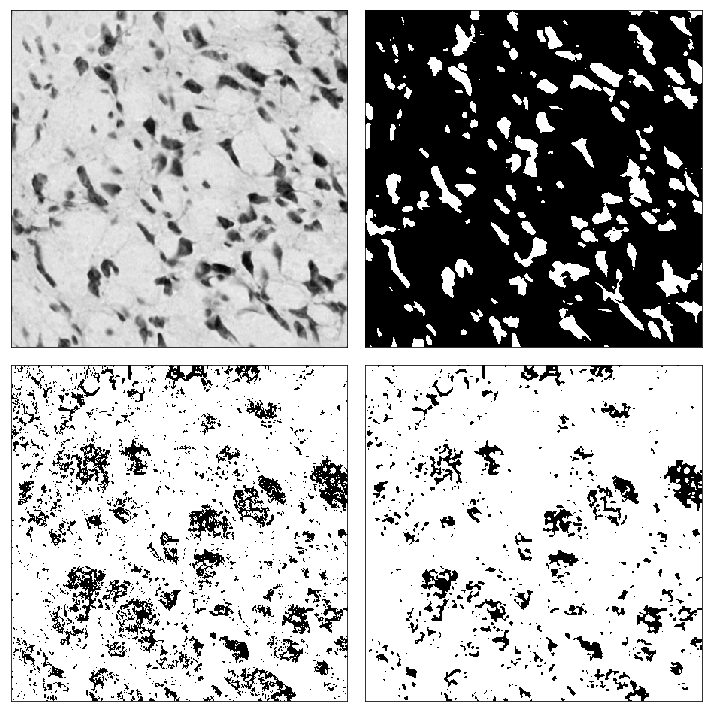

In [347]:
display_images_in_grids([patches[0],patches[0] < otsu_thresh, patches[0]<grad_threshold_gf, 
                         ndi.filters.gaussian_filter(patches[0],o_gass_filt_sigma)<grad_threshold_gf],nc=2, cmap=plt.cm.gray)

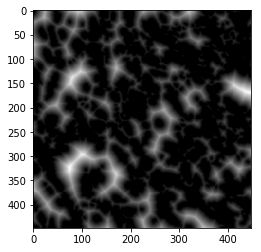

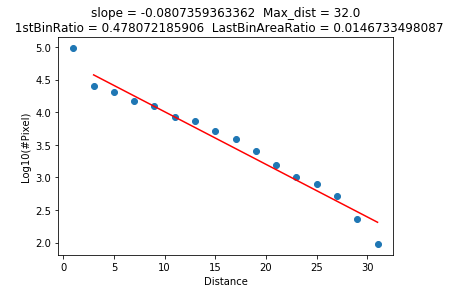

In [131]:
tempPatch = patches[0]
tempPatch_gs = ndi.filters.gaussian_filter(tempPatch, o_gass_filt_sigma)
tempPatch_DT_features, tempPatch_DT_im = fun_patch_features_DT(tempPatch_gs>grad_threshold_gf,patch_area=patch_area,showImQ=True)

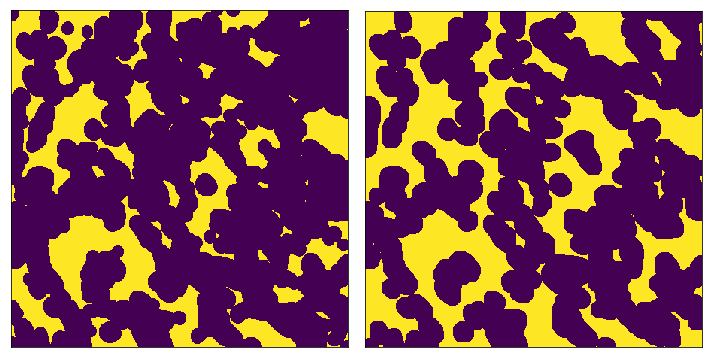

In [132]:
tempPatch_DT_im_BW = tempPatch_DT_im  >= skimage.filters.threshold_otsu(tempPatch_DT_im)
tempPatch_DT_im_o_BW = tempPatch_DT_im_o  >= skimage.filters.threshold_otsu(tempPatch_DT_im_o)
display_images_in_grids([tempPatch_DT_im_BW,tempPatch_DT_im_o_BW],nc=2)

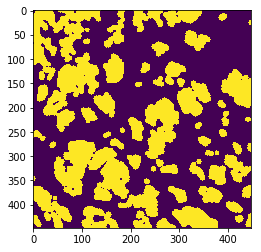

In [83]:
o_selem = skimage.morphology.disk(5)
plt.imshow(skimage.morphology.dilation(tempPatch_DT_im_BW,selem=o_selem))

### Conclusion 2 - gradient-matching threshold with gaussian filter
1. After gaussian filter, the gradient-matching threshold gives a good segmentation of the images. Compare with Otsu threshold, this method gives more detailed boundary. The best-alignment threshold depends on the size of the gaussian filter. 
    size_of_filter =   0    1    2    3    4  
    best_threshold = 218  218  200  195  190  
   Maybe a r = 2 gaussian filter filts out some not important details. Further increaseing the size of the gaussian filter will blur the boundary of the textures. Here we keed the size of the gaussian filter to be 2. 
2. The threshold found by gradient matching is generally higher than that of the otsu method. The reason might be that the color of the stained neuron is not uniform over the whole cell and the gradient-matching method pick up the cells with their boundarys. As a result, more cells are connected with each other on the BW images and thus gradient matching itself is not a good method to detect cells. 